## Exploratory Data Analysis

### Introduction 

The purpose of this notebook is to become familiar with the data, visually explore some of the variables of importance, and identify possible biases or issues. 


### Load libraries

In [1]:
import numpy as np 
import pandas as pd 
import wfdb 
import ast
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer


### Import data 

#### Auxiliary functions

Each patient's diagnosis is stored as an SCP code with the likelihood of the diagnosis based on the clinician's criteria. To reduce the complexity of the dataset, we've created two auxiliary functions that classify each SCP code in its corresponding diagnostic super-class and parses its likelihood. The diagnostic super-classes are:
- **NORM**: Normal ECG
- **CD**: Codunction Disturbance
- **MI**: Myocardial Infarction
- **HYP**: Hypertrophy
- **STTC**: ST/T change



In [2]:
def aggregate_diagnostic(agg_df:pd.DataFrame, database_scp:dict) -> list():
    """aggregate_diagnostic Returns the diagnostic superclass given an SCP code

    Args:
        agg_df (pd.DataFrame): Dataframe of aggregated diagnosis
        database_df (pd.DataFrame): Dictionary of SCP codes

    Returns:
        list: List of diagnostic super class
    """
    
    tmp = []
    for y_dic in database_scp:
        key_list  = list()
        for key in y_dic.keys():
            if key in agg_df.index:
                key_list.append(agg_df.loc[key].diagnostic_class)
        tmp.append(np.unique(key_list).tolist())
    return tmp

def aggregate_diagnostic_likelihood(agg_df:pd.DataFrame, database_df:pd.DataFrame, dx_classes:list) -> list():
    """aggregate_diagnostic_likelihood Appends the diagnostic likelihood for each superclass and subject

    Args:
        agg_df (pd.DataFrame): Dataframe of aggregated diagnosis
        database_df (pd.DataFrame): Database from Physionet
        dx_classes (list): List of diagnostic categories
    """
    
    # Create columns
    dx_lh_cols = [dx_class + "_lh" for dx_class in dx_classes] 
    database_df[dx_lh_cols] = ''
    
    # Add diagnostic likelihood
    for idx in database_df.index:
        scp_dict = database_df.loc[idx, 'scp_codes']
        for scp_code, scp_lh in scp_dict.items():
            if scp_code in agg_df.index:
                database_df.loc[idx, agg_df.loc[scp_code].diagnostic_class+"_lh"] = scp_lh     
    
    return database_df    

##### Data loading

We proceed now to import the data and make some changes to it that will help us analyze it, and target a specific goal. The following changes were conducted:
- Parse the diagnostic super-class, and likelihood.
- One-Hot Encoding of diagnostic super-classes.
- Males are now represented by a 1, and Female by a 0 in the *sex* variable.
- Changed the recording date to date-time format.
- Calculated the BMI. BMI is one of the best predictors of cardiovascular diseases.
- Dropped the samples with no diagnosis.
- Parsed the R-peaks provided by the clinician.

In [3]:
# Load options
with open('opts.json', 'r') as inFile:
    opts = json.load(inFile)
    
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(opts['file']['scp_statement'], index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# Load database and convert SCP codes to dicts, r_peaks to lists
database_df = pd.read_csv(opts['file']['ptbxl_database'], index_col=0)
database_df.scp_codes = database_df.scp_codes.apply(lambda x: ast.literal_eval(x))

# Change sex coding 
database_df.sex = [1 if sex == 0 else 0 for sex in database_df.sex]

# Parse diagnostic superclass and diagnostic likelihood
database_df['dx_super'] = aggregate_diagnostic(agg_df, database_df.scp_codes)

# Multilabel binarizer for superclass
mlb = MultiLabelBinarizer()
database_df[mlb.classes_] = mlb.fit_transform(database_df.dx_super)

# Convert to datetime
database_df['recording_date'] = pd.to_datetime(database_df.recording_date)

# Get superclass likelihood
database_df = aggregate_diagnostic_likelihood(agg_df, database_df, mlb.classes_)

# Calcualte BMI 
database_df['BMI'] = np.divide(database_df.weight, (database_df.height/100)**2)

# Conver r-peaks to list 
database_df.r_peaks = database_df.r_peaks.apply(lambda x: ast.literal_eval(x.replace('[  ','[').replace('[ ','[').replace('  ',' ').replace(' ',',')))

# Write 
database_df.to_csv('database_processed.csv')

#### Exploratory analysis

We proceed to explore critical variables that can bias the automatic detection of cardiopathies. In this case, we've focused in the two most important agents implied in cardiovascular disases (CVD): age and sex. Intuitively, age is associated with a higher risk of CVDs, and we may see and increased number of specific CVDs in older patients. Therefore, we need to verify that the dataset is relatively balanced in the most aged population. Sex also plays an important role in CVD. For instance, age-specific CVD rates are lower in women than in men, and CVD rates incrase in women with age, making sex an important variable to study.

First, let's have a look at the age distribution and the sex count.

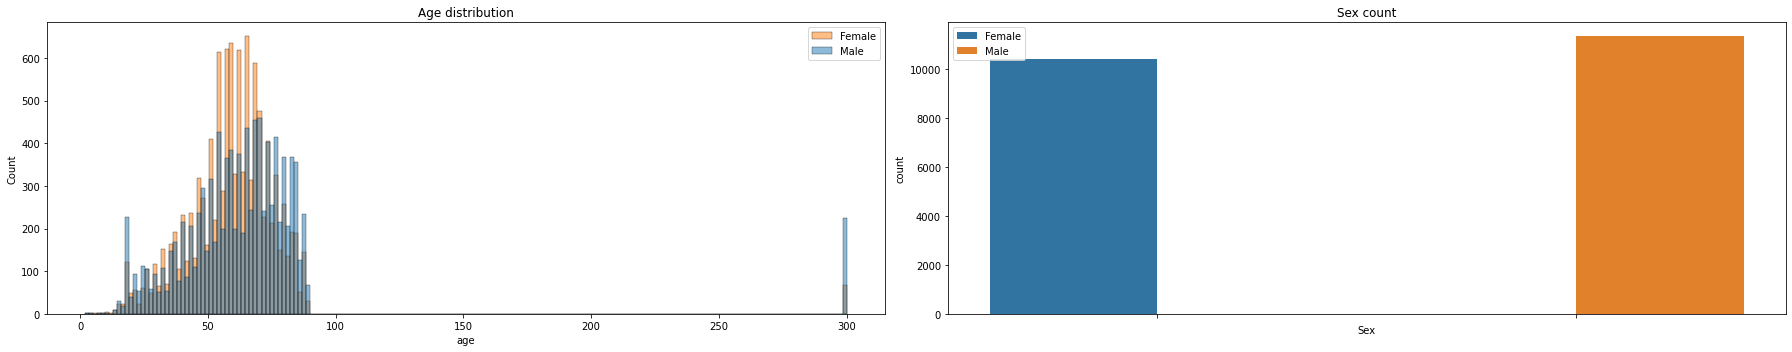

In [4]:
# Check age 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (25,5)
fig, axes = plt.subplots(1,2)
age_h = sns.histplot(data=database_df, x='age', hue='sex', ax=axes[0])
axes[0].set_title('Age distribution')
axes[0].legend(loc='upper right', labels=['Female', 'Male'])
axes[0].set_label('Age')
sex_c = sns.countplot(data=database_df, x='sex', hue='sex', ax=axes[1])
axes[1].set_title('Sex count')
axes[1].set_xlabel('Sex')
axes[1].legend(loc='upper left', labels=['Female', 'Male'])
axes[1].set_xticklabels(['',''])
plt.tight_layout()

One of the first things that we notice is that there is a remarkable number of patients older than 99 (which have been labeled as 300 years old for privacy reasons). Because age is one of the highest risk factors for cardiovascular diseases, in addition to assessing the whole cohort, we will evaluate the differences between patients younger than 99 and older than 99. 

We also want to check the average age by diagnosis. In this case, we've removed patients older than 99 to avoid biases.

[]

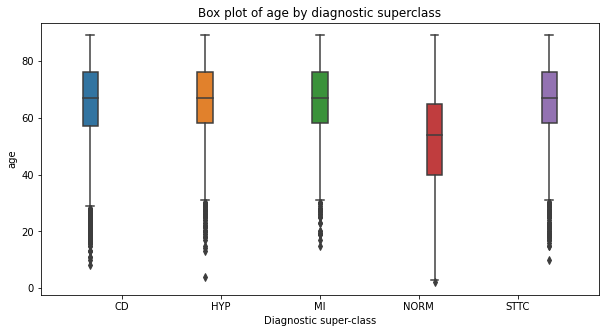

In [5]:
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10,5)
age_melt = database_df.melt(['age'],['CD', 'HYP', 'MI', 'NORM', 'STTC'])
age_melt = age_melt[age_melt.value == 1]
bp = sns.boxplot(data=age_melt[age_melt.age < 100], x='variable', y='age', hue='variable')
bp.legend_.remove()
bp.set_title('Box plot of age by diagnostic superclass')
bp.set_xlabel('Diagnostic super-class')
plt.plot()

Noticeably, the average age of Normal ECGs is ~10 years younger than the rest of the diagnostic categories. This is something to consider because ECG patterns and shapes are likely to change with age. 

We now proceed to evaluate the differences in BMI, age and counts of positive diagnosis for the whole cohort of patients, patients younger than 99, and patients older than 99.

[]

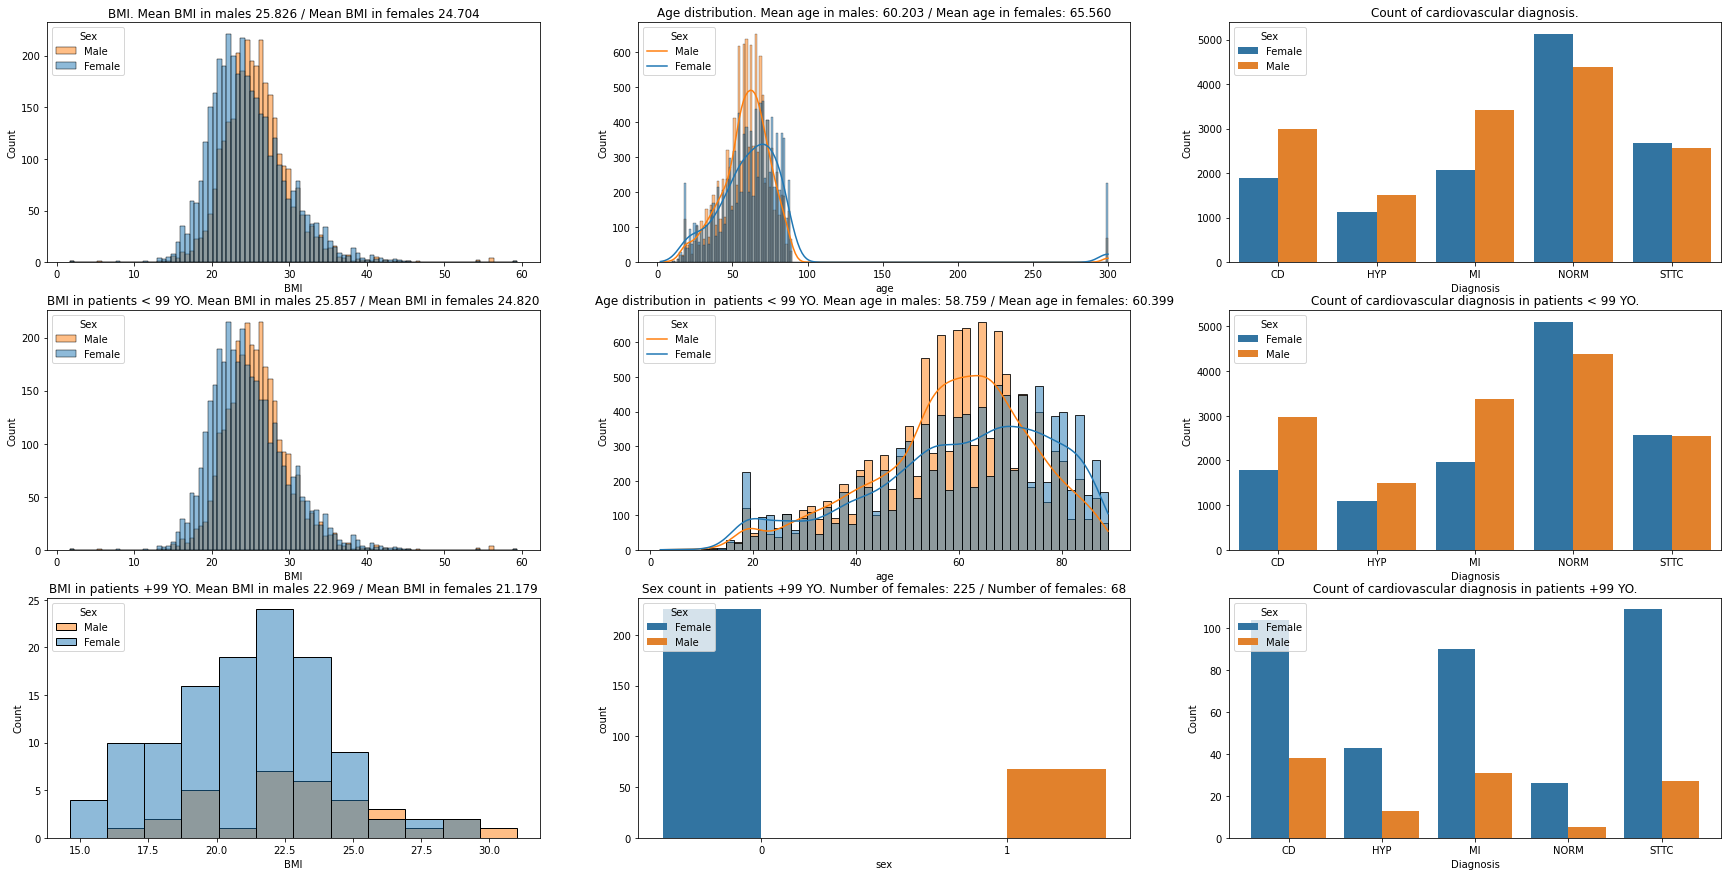

In [6]:
# Separate dataframes
database_df_y99 = database_df[database_df.age <= 100]
database_df_o99 = database_df[database_df.age > 100]

# Create melted dataframe 
melted_df = database_df.melt('sex',['CD', 'HYP', 'MI', 'NORM', 'STTC'])
melted_df_y99 = database_df_y99.melt('sex',['CD', 'HYP', 'MI', 'NORM', 'STTC'])
melted_df_o99 = database_df_o99.melt('sex',['CD', 'HYP', 'MI', 'NORM', 'STTC'])


%matplotlib inline 
plt.rcParams['figure.figsize']=(30,15)

# All cohort
fig, axes = plt.subplots(3,3)
h = sns.histplot(data=database_df, x="BMI", hue='sex', ax=axes[0,0])
h.set_title('BMI. Mean BMI in males {:.3f} / Mean BMI in females {:.3f}'.format(np.mean(database_df.loc[database_df.sex == 1, 'BMI']), np.mean(database_df.loc[database_df.sex==0, 'BMI'])))
axes[0,0].legend(title='Sex', loc='upper left', labels=['Male', 'Female'])
plt.plot()
h2 = sns.histplot(data=database_df, x='age', hue='sex', ax=axes[0,1], kde='gaussian')
h2.set_title('Age distribution. Mean age in males: {:.3f} / Mean age in females: {:.3f}'.format(np.mean(database_df.loc[database_df.sex ==1, 'age']), np.mean(database_df.loc[database_df.sex==0, 'age'])))
axes[0,1].legend(title='Sex', loc='upper left', labels=['Male', 'Female'])
cp = sns.countplot(data=melted_df[melted_df.value==1], x='variable', hue='sex', ax=axes[0,2])
cp.set_title('Count of cardiovascular diagnosis.')
axes[0,2].legend(title='Sex', loc='upper left', labels=['Female', 'Male'])
axes[0,2].set_xlabel('Diagnosis')
axes[0,2].set_ylabel('Count')
plt.plot()

# Younger than 99
h = sns.histplot(data=database_df_y99, x="BMI", hue='sex', ax=axes[1,0])
h.set_title('BMI in patients < 99 YO. Mean BMI in males {:.3f} / Mean BMI in females {:.3f}'.format(np.mean(database_df_y99.loc[database_df_y99.sex == 1, 'BMI']), np.mean(database_df_y99.loc[database_df_y99.sex==0, 'BMI'])))
axes[1,0].legend(title='Sex', loc='upper left', labels=['Male', 'Female'])
plt.plot()
h2 = sns.histplot(data=database_df_y99, x='age', hue='sex', ax=axes[1,1], kde='gaussian')
h2.set_title('Age distribution in  patients < 99 YO. Mean age in males: {:.3f} / Mean age in females: {:.3f}'.format(np.mean(database_df_y99.loc[database_df_y99.sex ==1, 'age']), 
    np.mean(database_df_y99.loc[database_df_y99.sex==0, 'age'])))
axes[1,1].legend(title='Sex', loc='upper left', labels=['Male', 'Female'])
cp = sns.countplot(data=melted_df_y99[melted_df_y99.value==1], x='variable', hue='sex', ax=axes[1,2])
cp.set_title('Count of cardiovascular diagnosis in patients < 99 YO.')
axes[1,2].legend(title='Sex', loc='upper left', labels=['Female', 'Male'])
axes[1,2].set_xlabel('Diagnosis')
axes[1,2].set_ylabel('Count')
plt.plot()

# Older than 99
h = sns.histplot(data=database_df_o99, x="BMI", hue='sex', ax=axes[2,0])
h.set_title('BMI in patients +99 YO. Mean BMI in males {:.3f} / Mean BMI in females {:.3f}'.format(np.mean(database_df_o99.loc[database_df_o99.sex == 1, 'BMI']), np.mean(database_df_o99.loc[database_df_o99.sex==0, 'BMI'])))
axes[2,0].legend(title='Sex', loc='upper left', labels=['Male', 'Female'])
plt.plot()
h2 = sns.countplot(data=database_df_o99, x='sex', hue='sex', ax=axes[2,1])
h2.set_title('Sex count in  patients +99 YO. Number of females: {} / Number of females: {}'.format(database_df_o99.sex.value_counts()[0], database_df_o99.sex.value_counts()[1]))
axes[2,1].legend(title='Sex', loc='upper left', labels=['Female', 'Male'])
cp = sns.countplot(data=melted_df_o99[melted_df_o99.value==1], x='variable', hue='sex', ax=axes[2,2])
cp.set_title('Count of cardiovascular diagnosis in patients +99 YO.')
axes[2,2].legend(title='Sex', loc='upper left', labels=['Female', 'Male'])
axes[2,2].set_xlabel('Diagnosis')
axes[2,2].set_ylabel('Count')
plt.plot()


Remarkably, most patients older than 99 are females, and we appreciate a much fewer number of normal ECGs. Nonetheless, these differences do not seem to affect the overall cohort by much.

#### Diagnostic likelihood

We've noticed that in the supercategories of diagnosis some patients were labeled as having Normal ECG and Myocardial Infarction simultaneously. This is because we've treated diagnoses as absolute categories. However, each SCP code is accompanied by a diagnostic likelihood provided by the clinician. This is probably one of the most important features, as it defines the reliability of the diagnosis. We're interested in understanding whether some diagnoses have a higher or lower likelihood than others and whether they differ in our two age groups (older and younger than 99), as well as to know the number of diagnoses which likelihood is smaller than 100%.

[]

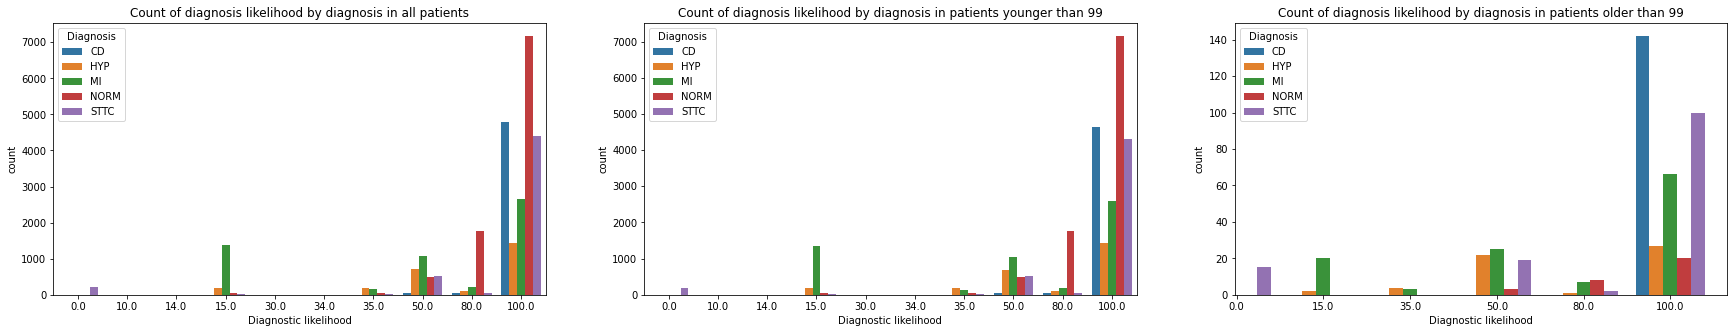

In [7]:

# Melt databases to get likelihoods
lh_melt = database_df.melt([],['CD_lh', 'HYP_lh', 'MI_lh', 'NORM_lh', 'STTC_lh'])
lh_melt = lh_melt[lh_melt.value != '']

lh_melt_o99 = database_df_o99.melt([],['CD_lh', 'HYP_lh', 'MI_lh', 'NORM_lh', 'STTC_lh'])
lh_melt_o99 = lh_melt_o99[lh_melt_o99.value != '']

lh_melt_y99 = database_df_y99.melt([],['CD_lh', 'HYP_lh', 'MI_lh', 'NORM_lh', 'STTC_lh'])
lh_melt_y99 = lh_melt_y99[lh_melt_y99.value != '']

# Plot
%matplotlib inline 
plt.rcParams['figure.figsize']=(30,5)

# Whole cohort
fig, axes = plt.subplots(1,3)
cp = sns.countplot(data=lh_melt, x='value', hue='variable', ax=axes[0])
axes[0].legend(title='Diagnosis', loc='upper left', labels=['CD','HYP','MI','NORM','STTC'])
axes[0].set_title('Count of diagnosis likelihood by diagnosis in all patients')
axes[0].set_xlabel('Diagnostic likelihood')
plt.plot()

# Younger than 99
cp = sns.countplot(data=lh_melt_y99, x='value', hue='variable', ax=axes[1])
axes[1].legend(title='Diagnosis', loc='upper left', labels=['CD','HYP','MI','NORM','STTC'])
axes[1].set_title('Count of diagnosis likelihood by diagnosis in patients younger than 99')
axes[1].set_xlabel('Diagnostic likelihood')
plt.plot()

# Older than 00
cp = sns.countplot(data=lh_melt_o99, x='value', hue='variable', ax=axes[2])
axes[2].legend(title='Diagnosis', loc='upper left', labels=['CD','HYP','MI','NORM','STTC'])
axes[2].set_title('Count of diagnosis likelihood by diagnosis in patients older than 99')
axes[2].set_xlabel('Diagnostic likelihood')
plt.plot()


Interestingly, we see that Myocardial Infarcion has a lower reliability, given that a significant amount of the diagnosis have a likelihood of 15% in the population younger than 99%. In addition, Normal ECG is the predominant diangosis with a likelihood of 80%. In the older population, we see a similar pattern.

## Signal visualization
Let's have a look at the some of the signals to get an idea of what they look like. First, let's get a randome subject and plot the ECG.

[]

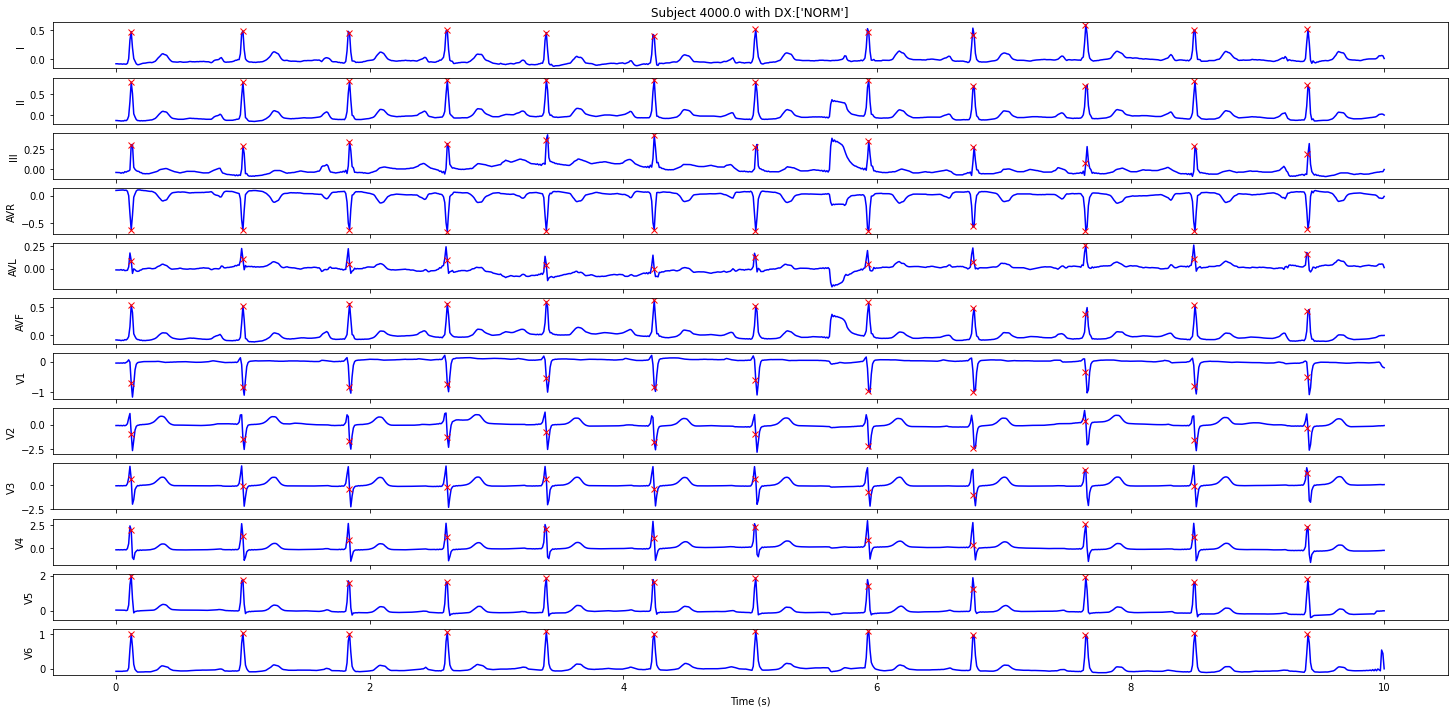

In [16]:
# Pick a random subject 
rand_int = np.random.randint(low=0, high=database_df.shape[0])

# Get R peaks
r_peaks = database_df.r_peaks.loc[rand_int]

# Read subject and plot 
signal, meta = wfdb.rdsamp(opts['path']['physionet'] + database_df.filename_lr.loc[rand_int])
r_peaks_s =  np.divide(r_peaks, meta['fs'])

%matplotlib inline
plt.rcParams['figure.figsize']=(25,12)
signal_df = pd.DataFrame(signal)
signal_df.columns = meta['sig_name']
signal_df['t_vec'] = np.linspace(0, signal_df.shape[0], signal_df.shape[0])/meta['fs']
axes = signal_df.plot(x='t_vec', y=meta['sig_name'], subplots=True, color='blue', legend=False)
axes[0].set_title('Subject {} with DX:{}'.format(database_df.patient_id.loc[rand_int], database_df.dx_super.loc[rand_int]))
for i in range(0,signal_df.shape[1]-1):
    axes[i].set_ylabel(meta['sig_name'][i])
    axes[i].plot(r_peaks_s, signal[r_peaks,i], 'rx')
axes[-1].set_xlabel('Time (s)')
plt.plot()

We want to know how each diagnosis ECG may differentiate. Let's look at the first 5 seconds of a random subject from each diagnosis to get a comparison.

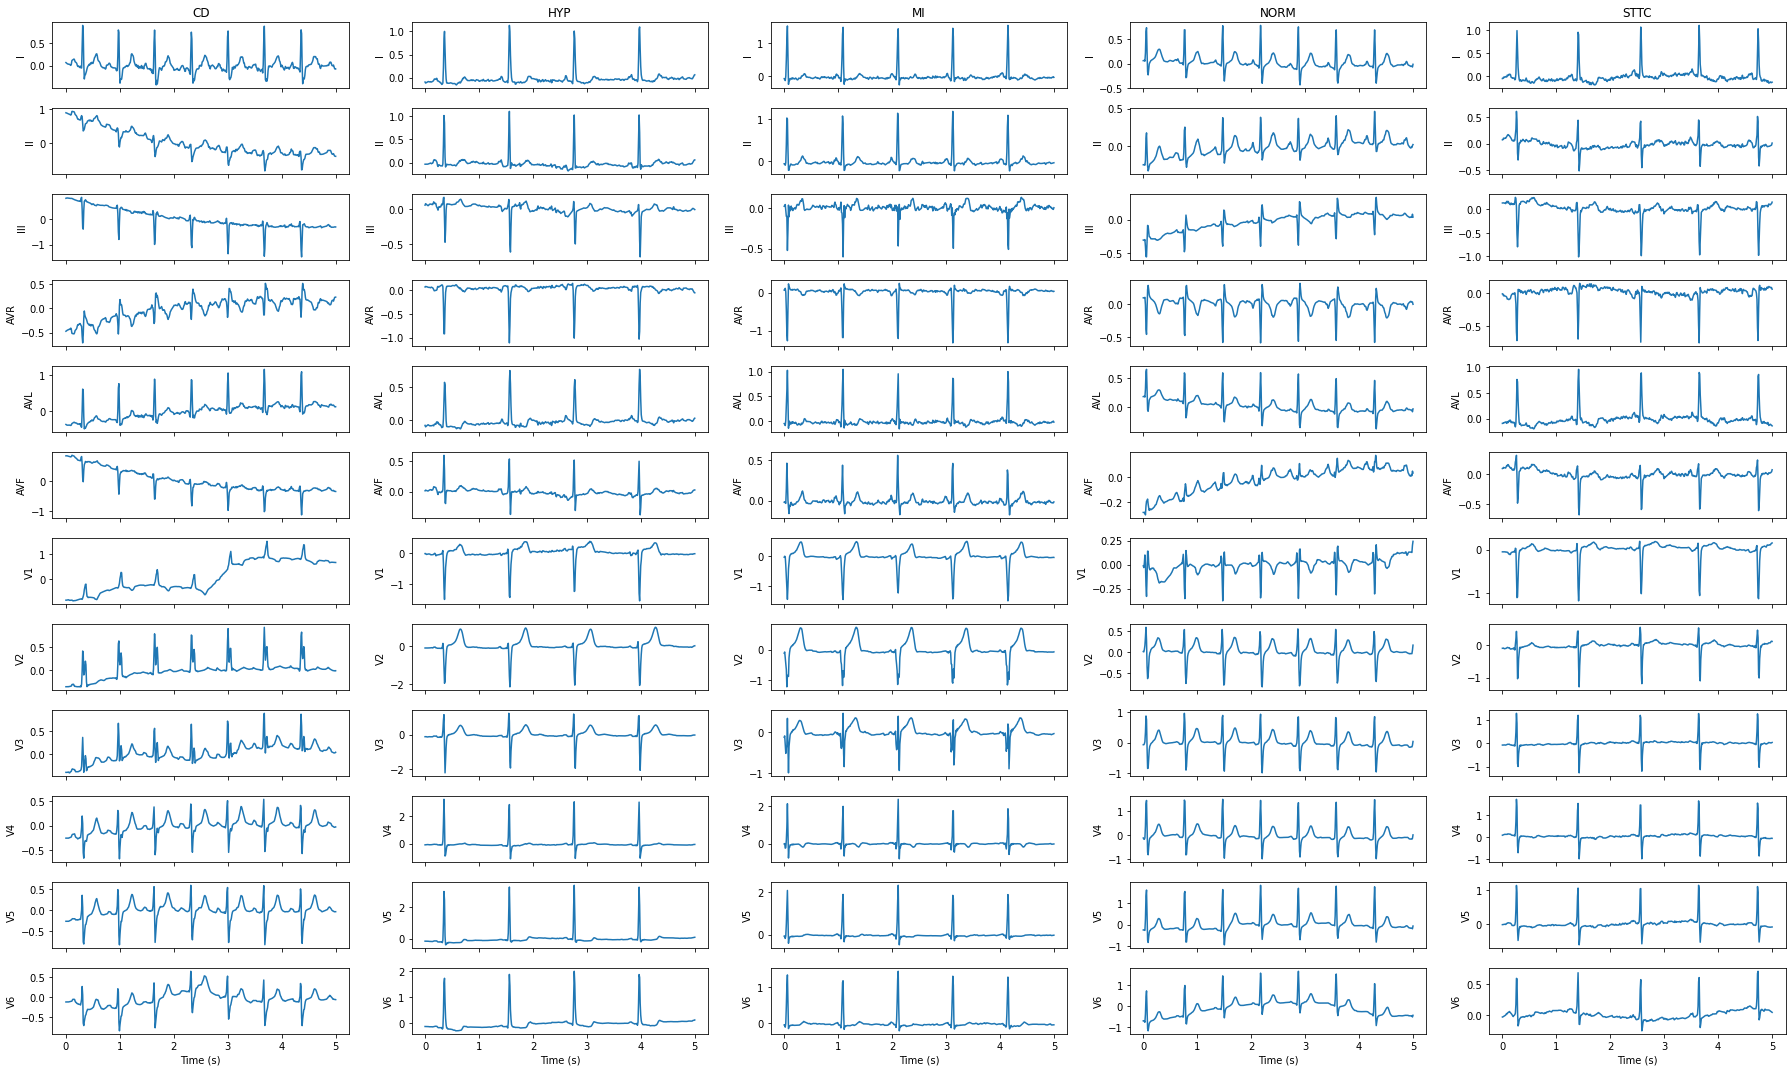

In [23]:
# Dx classes
dx_classes = ['CD', 'HYP', 'MI', 'NORM', 'STTC']

# Plot 
%matplotlib inline 
plt.rcParams['figure.figsize']=(25,15)
fig, axes = plt.subplots(12,5, sharey=False, sharex=True)
for idx, dx in enumerate(dx_classes):
    
    # Get random subject 
    rand_subj = database_df.loc[database_df[dx] == 1, 'patient_id'].sample().iloc[0]
    signal, meta = wfdb.rdsamp(opts['path']['physionet'] + database_df[database_df.patient_id == rand_subj].filename_lr.iloc[0])
    signal_init = signal[0:500,:]
    
    # Plot
    for ci in range(signal_init.shape[1]):
        t_vector = np.linspace(0, signal_init.shape[0], signal_init.shape[0])/meta['fs']
        signal_plot = pd.DataFrame({'t':t_vector, 'y':signal_init[:,ci]})
        sns.lineplot(x='t', y='y', data=signal_plot, ax=axes[ci,idx])
        axes[ci, idx].set_ylabel(meta['sig_name'][ci])
        plt.plot()
    axes[-1,idx].set_xlabel('Time (s)')
for ax, col in zip(axes[0], dx_classes):
    ax.set_title(col)

plt.tight_layout()
    


Finally, let's have a look at patients with the same diagnosis, but with a likelihood of 35% and 100%.

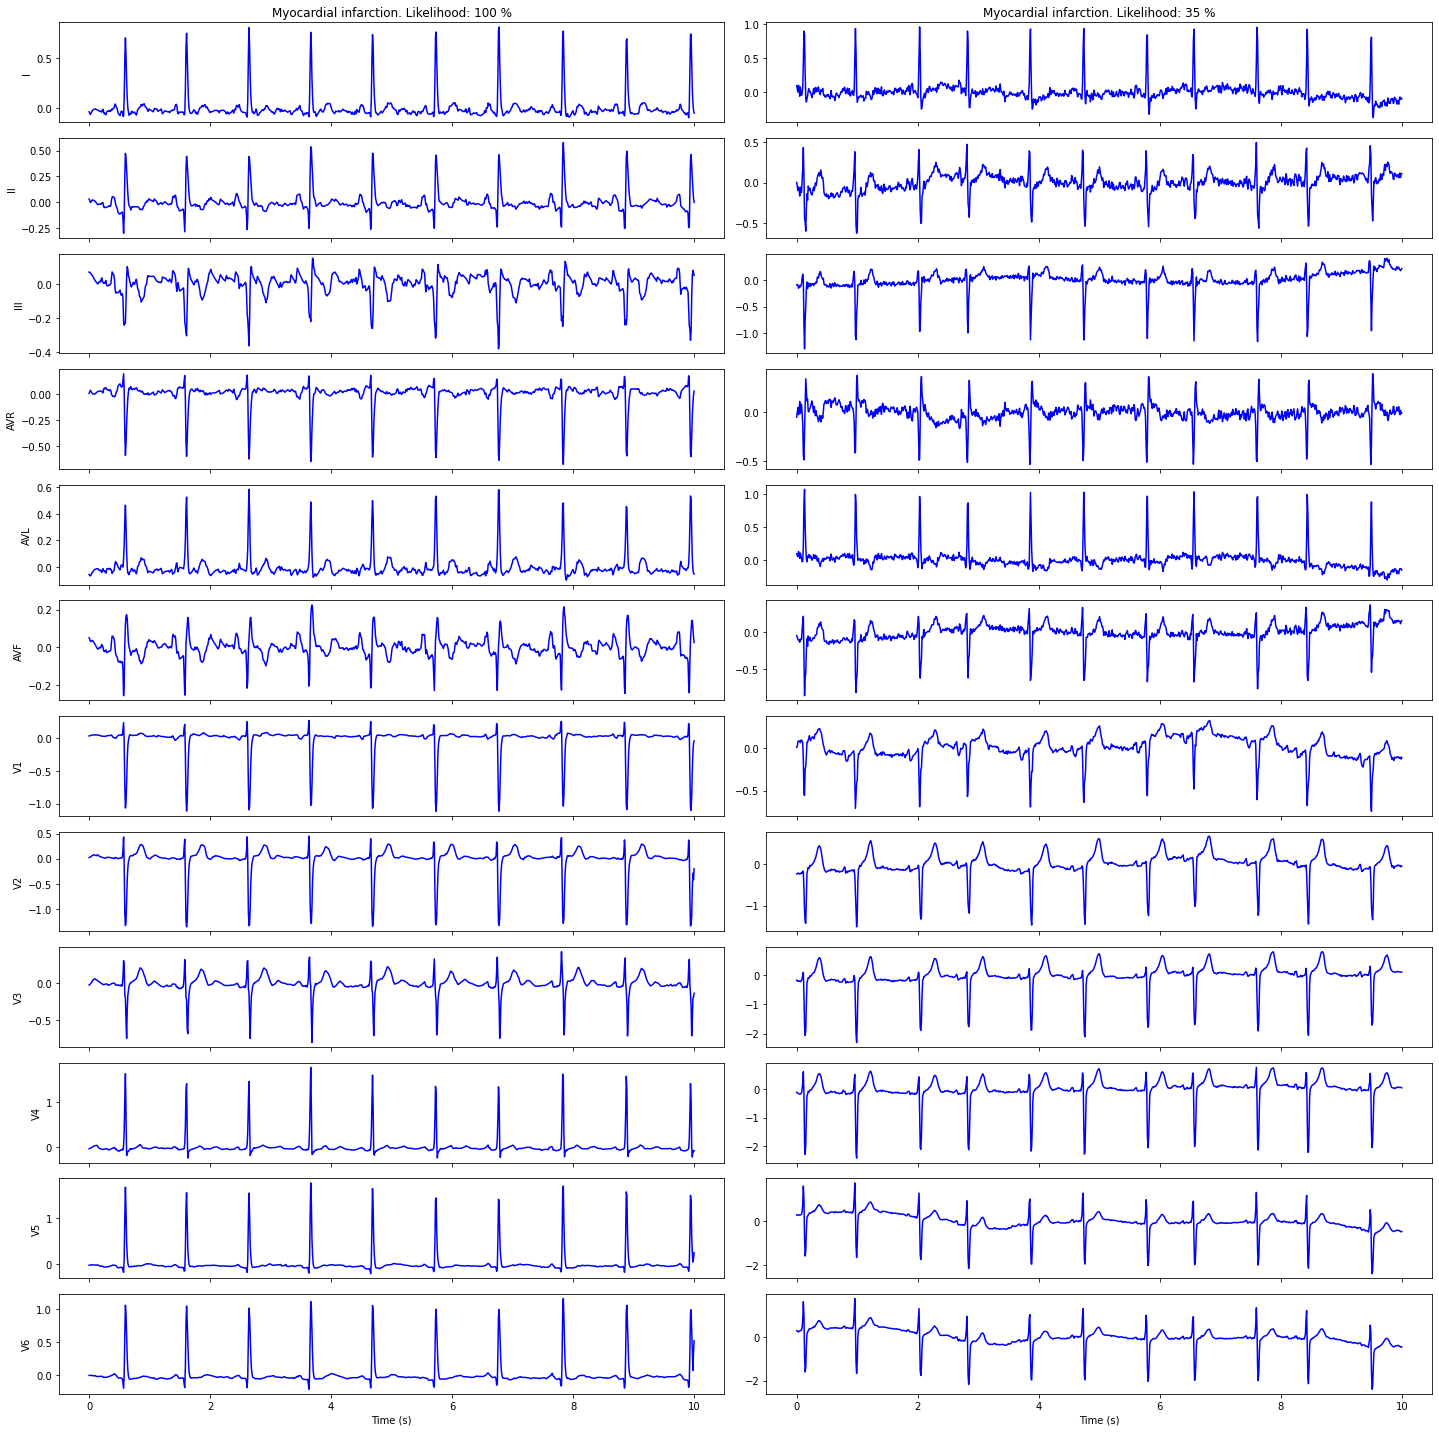

In [29]:
# MI patient
rand_high_lh = database_df[database_df.MI_lh == 100].sample()
rand_low_lh = database_df[database_df.MI_lh == 35].sample()

# Read their recordings
signal_high, meta_high = wfdb.rdsamp(opts['path']['physionet'] + rand_high_lh.filename_lr.iloc[0])
signal_low, meta_low = wfdb.rdsamp(opts['path']['physionet'] + rand_low_lh.filename_lr.iloc[0])

# Get signal names
signal_high_df = pd.DataFrame(signal_high)
signal_high_df.columns = meta['sig_name']
signal_low_df = pd.DataFrame(signal_low)
signal_low_df.columns = meta['sig_name']

# Add time vector
t_vec = np.linspace(0, signal_high_df.shape[0], signal_high_df.shape[0])/meta['fs']
signal_high_df['t_vec'], signal_low_df['t_vec'] = t_vec, t_vec

# Plot
%matplotlib inline 
plt.rcParams['figure.figsize']=(20,20)
fig, axes = plt.subplots(12,2, sharex=True)
signal_high_df.plot(x='t_vec', y=meta['sig_name'],subplots=True, color='blue', legend=False, ax=axes[:,0])
signal_low_df.plot(x='t_vec', y=meta['sig_name'], subplots=True, color='blue', legend=False, ax=axes[:,1])
axes[-1,0].set_xlabel('Time (s)')
axes[-1,1].set_xlabel('Time (s)')
for ax, lh in zip(axes[0], [100,35]):
    ax.set_title('Myocardial infarction. Likelihood: {} %'.format(lh))

for i in range(0,signal_high_df.shape[1]-1):
    axes[i,0].set_ylabel(meta['sig_name'][i])
plt.plot()
plt.tight_layout()


### Ideas

This EDA has mostly focused on studying the age, sex, diagnostic super-class, and the likelihood of the diagnosis. We've also visualized some signals to get a general idea of what they look like. However, there are some other variables worth looking at, that we have not included in this EDA for simplicity. For instance:
- **Year of recording:** It'd be interesting to check whether the year of the recording is associated with diagnosis. At best, we'd see similar diagnostic frequencies per year, and at worst, changes in frequencies according to popoulation trends. 
- **Time of the recording:** It's well known that humans are more prone to make make biased decisions in certain hours of the day (e.g. before lunch, at the end of the workday). Should we differences in diagnosis along the day, it may indicate that clinicians are biased towards specific diagnostic categories.
- **Recording device:** Ideally, we should see tha same diagnostic frequency in each device. Otherwise, it could mean that certain devices are influcing diagnosis in clinicians.   
- **Nurse/clinicians:** Humans have inherent biases that make us take some decisions more often than others. It'd be worth studying whether some clinicians are more likely to give a certain diagnosis. Similarly, whether there are clinicians that are more sure of themselves (and therefore their diagnosis has a higher likelihood), or not (lower likelihood).